# Image processing with satellite data

## Small-scale computations on a laptop

This notebook performs calculations with a GeoTIFF dataset using XArray and Dask. We load and rescale a Landsat 8 image and compute the normalized difference vegetation index (NDVI), which distinguishes green vegetation from areas of bare land or water.

We'll use an image of the Denver, USA area taken in July 2018.

![RGB image](https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_thumb_small.jpg)

## Step 1: Import packages

In [1]:
import dask
import json
import os
import rasterio
import requests
import rioxarray
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2: Download input data/images

We are using images from the [Landsat dataset on GCP](https://cloud.google.com/storage/docs/public-datasets/landsat) and each band is available as a separate GeoTIFF file.

In [2]:
nir_url = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B5.TIF"
red_url = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B4.TIF"
mtl_url = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_MTL.txt"

In [3]:
nir_filename = "../data/LC08_L1TP_033033_20180706_20180717_01_T1_B5.TIF"
red_filename = "../data/LC08_L1TP_033033_20180706_20180717_01_T1_B4.TIF"
mtl_filename = "../data/LC08_L1TP_033033_20180706_20180717_01_T1_MTL.txt"

In [4]:
def download_file(url, filename):
    if not os.path.exists(filename):
        r = requests.get(url, allow_redirects=True)
        open(filename, "wb").write(r.content)

In [5]:
download_file(nir_url, nir_filename)
download_file(red_url, red_filename)
download_file(mtl_url, mtl_filename)

## Step 3: Create XArray datasets

In [6]:
import xarray as xr
red = rioxarray.open_rasterio(red_filename, chunks={'band': 1, 'x': 1024, 'y': 1024})
nir = rioxarray.open_rasterio(nir_filename, chunks={'band': 1, 'x': 1024, 'y': 1024})
nir

<xarray.DataArray (band: 1, y: 7841, x: 7721)>
dask.array<open_rasterio-8c066d8207947078e366581fe074082d<this-array>, shape=(1, 7841, 7721), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.134e+05 4.134e+05 4.135e+05 ... 6.45e+05 6.45e+05
  * y            (y) float64 4.423e+06 4.423e+06 ... 4.188e+06 4.188e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

## Step 4: Create a local Dask cluster on our laptop

In [7]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56369,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://192.168.1.164:56379,Total threads: 4
Dashboard: http://192.168.1.164:56381/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:56371,


## Step 5: Rescale bands using Landsat metadata and Dask

The Landsat Level 1 images are delivered in a quantized format. This has to be [converted to top-of-atmosphere reflectance](https://landsat.usgs.gov/using-usgs-landsat-8-product) using the provided metadata. First we define convenience functions to load the rescaling factors and transform a dataset. The red band is band 4 and near infrared is band 5.

In [8]:
def load_scale_factors(filename, band_number):
    metadata = {}
    with open(filename) as MTL:
        for line in MTL:
            name, var = line.partition("=")[::2]
            metadata[name.strip()] = var
    
    M_p = float(metadata["REFLECTANCE_MULT_BAND_{}".format(band_number)])
    A_p = float(metadata["REFLECTANCE_ADD_BAND_{}".format(band_number)])
    
    return M_p, A_p

def calculate_reflectance(ds, band_number, metafile=mtl_filename):
    M_p, A_p = load_scale_factors(metafile, band_number)
    toa = M_p * ds + A_p
    return toa

red_toa = calculate_reflectance(red, band_number=4)
nir_toa = calculate_reflectance(nir, band_number=5)

Because the transformation is composed of arithmetic operations, execution is delayed and the operations are parallelized automatically.

In [9]:
print(red_toa.variable.data)

dask.array<add, shape=(1, 7841, 7721), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>


The resulting image has floating point data with magnitudes appropriate to reflectance. This can be checked by computing the range of values in an image using Dask:

In [10]:
red_max, red_min, red_mean = dask.compute(
    red_toa.max(dim=['x', 'y']), 
    red_toa.min(dim=['x', 'y']),
    red_toa.mean(dim=['x', 'y'])
)
print(red_max.item())
print(red_min.item())
print(red_mean.item())

1.2107
-0.1
0.05921340355007137


## Step 6: Calculate and display normalized difference vegetation index (NDVI) using Dask

Now that we have the image as reflectance values, we are ready to compute the NDVI using Dask.

$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

This highlights areas of healthy vegetation with high NDVI values, which appear as green in the image below.

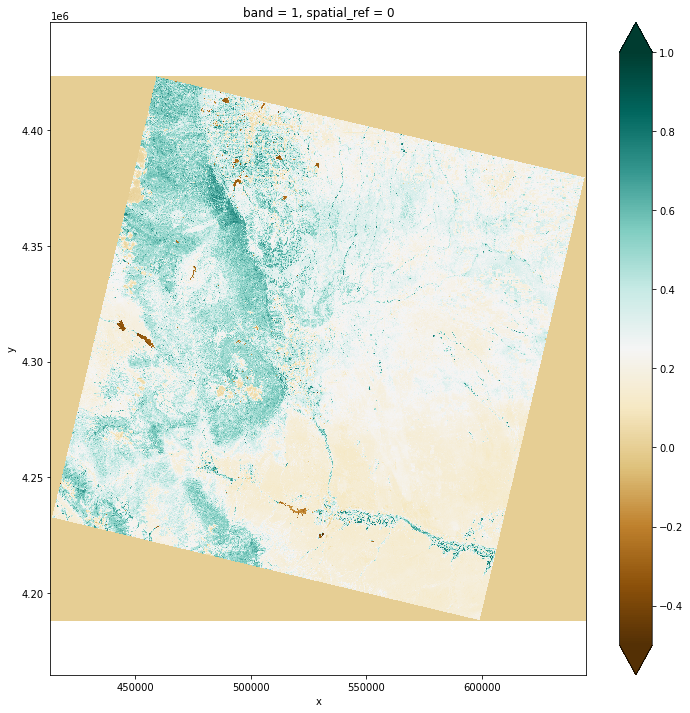

CPU times: user 3.58 s, sys: 1.19 s, total: 4.77 s
Wall time: 4.22 s


In [11]:
%%time

ndvi = (nir_toa - red_toa) / (nir_toa + red_toa)
ndvi2d = ndvi.squeeze()

fig = plt.figure(figsize=[12,12])
im = ndvi2d.compute().plot.imshow(cmap='BrBG', vmin=-0.5, vmax=1)
plt.axis('equal')
plt.show()
fig.savefig("output/LC08_L1TP_033033_20180706_20180717_01_T1.png")